# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [44]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests

# Import API key
from api_keys import geoapify_key

In [45]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("Output_PY/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,edinburgh of the seven seas,-37.0676,-12.3116,14.22,82,100,5.29,SH,06-18-2024
1,1,georgetown,5.4112,100.3354,26.97,83,20,1.03,MY,06-18-2024
2,2,ushuaia,-54.8000,-68.3000,-1.19,74,75,3.09,AR,06-18-2024
3,3,pupri,26.4833,85.7167,27.57,83,100,6.27,IN,06-18-2024
4,4,kargasok,59.0556,80.8572,5.33,63,2,5.69,RU,06-18-2024


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

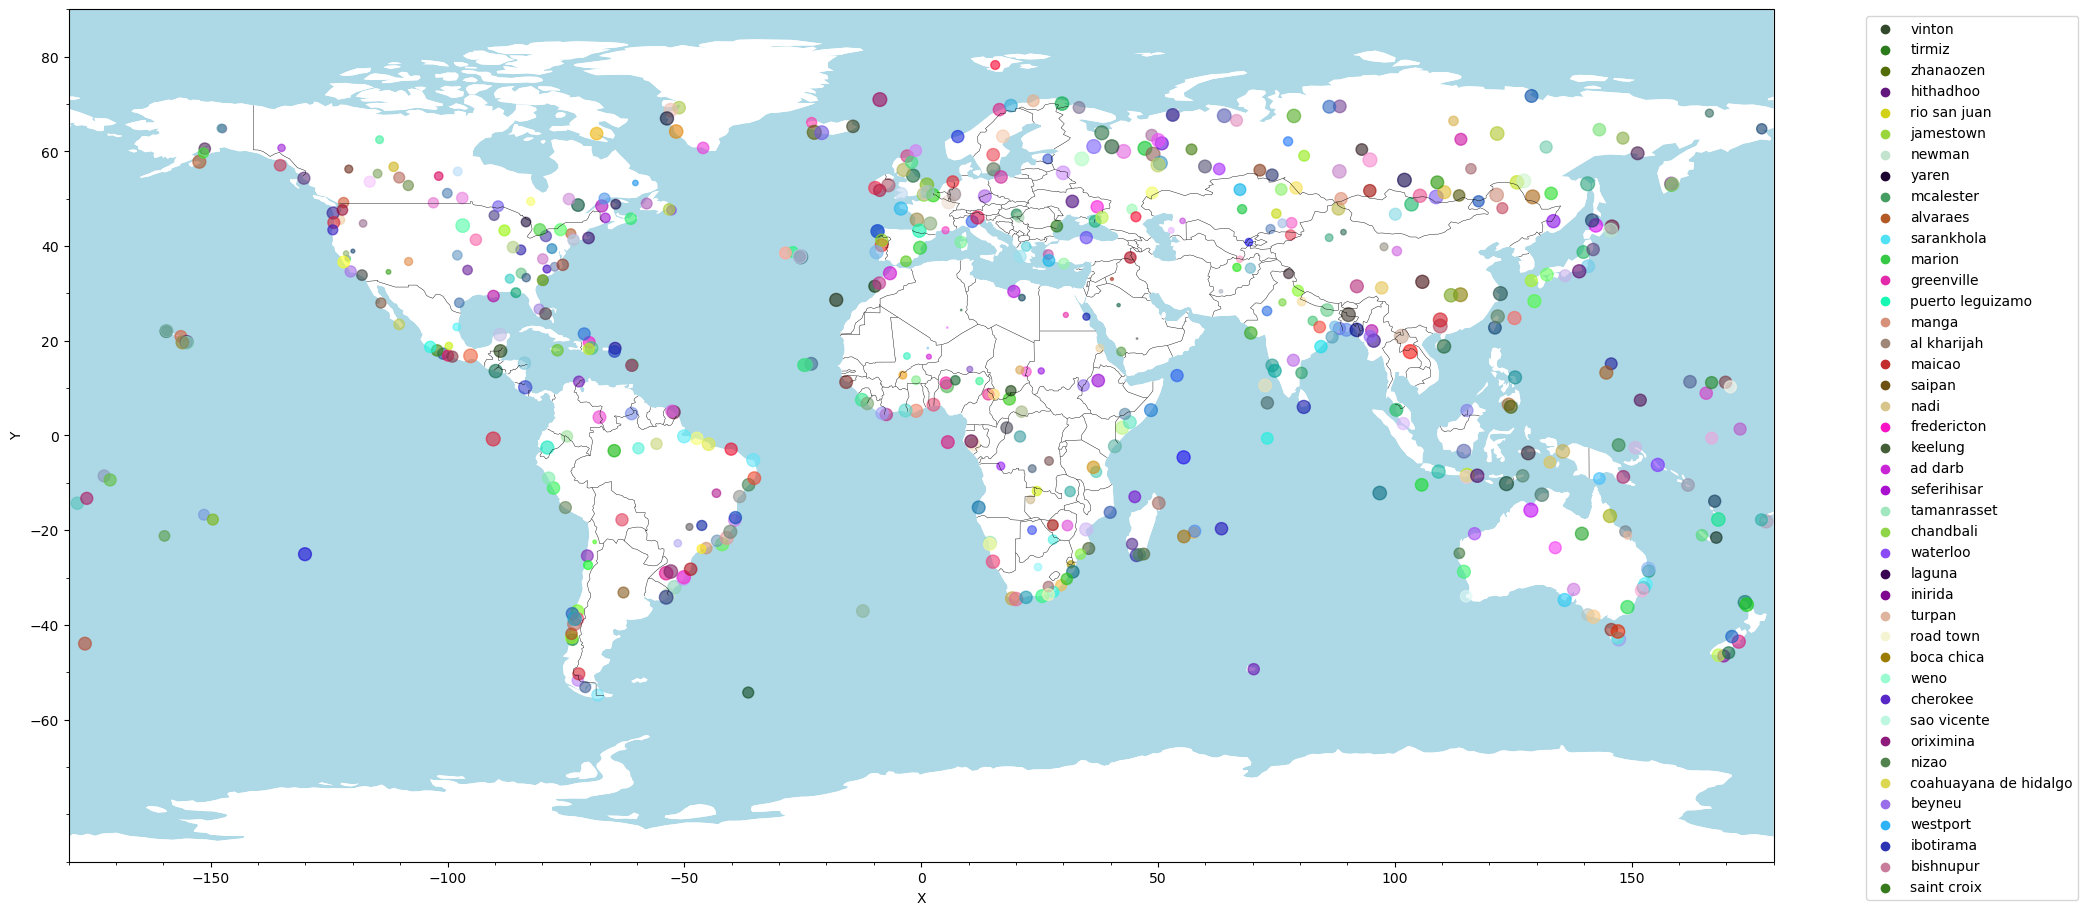

In [57]:
%%capture --no-display

# Configure the map plot
#Dependencies
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.ticker import MultipleLocator

# Create a new figure with a spisicic map projection
fig, ax = plt.subplots(figsize=(22, 24), subplot_kw={'projection': ccrs.PlateCarree()})
# Add visualization of global geographical data on a 2D plan
ax.set_global()

# Add ocean and land features with white and lightblue colors to match the assigment output
ax.add_feature(cfeature.OCEAN, facecolor='lightblue') 
ax.add_feature(cfeature.LAND, facecolor='white')  
# Add countries borders (thing lines)    
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.3)  

# Normalize humidity values for scaling the sizes
size_norm = plt.Normalize(city_data_df['Humidity'].min(), city_data_df['Humidity'].max())

# Generate a random colors for different cities
np.random.seed(0)  # for reproducibility
colors = np.random.rand(len(city_data_df), 3)  # generates an array of random colors

# Plot each city with a size and color scaled by 'Humidity'
scatter = ax.scatter(city_data_df['Lng'], city_data_df['Lat'], s=size_norm(city_data_df['Humidity'])*100,  
                     color=colors, alpha=0.6)

# Set x and y labels to match assignment output
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set x and y ticks
ax.set_xticks([-150, -100, -50, 0, 50, 100, 150])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60, 80])

# Add minor ticks for the scale with dividers of 10
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))

# Adding a legend with cities to match assignment output
handles = []
for city in hotel_df['City'].unique():
    handles.append(ax.scatter([], [], color=np.random.rand(3,), label=city))

ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the map
plt.show()

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [47]:
# Narrow down cities that fit criteria and drop any results with null values
ideal_weather = city_data_df[(city_data_df['Max Temp'] >= 28) & 
                             (city_data_df['Max Temp'] <= 33) & 
                             (city_data_df['Wind Speed'] < 5)]

# Drop any rows with null values
ideal_weather = ideal_weather.dropna()

# Display sample data
print(ideal_weather)

     City_ID                   City      Lat       Lng  Max Temp  Humidity  \
7          7                 vinton  37.2810  -79.8970     32.60        58   
24        24                 tirmiz  37.2242   67.2783     28.05        28   
49        49              zhanaozen  43.3000   52.8000     32.63        24   
134      134              hithadhoo  -0.6000   73.0833     28.32        72   
142      142           rio san juan  19.6439  -70.0763     28.36        74   
143      143              jamestown  42.0970  -79.2353     30.81        66   
151      151                 newman  37.3138 -121.0208     30.99        21   
157      157                  yaren  -0.5472  166.9160     28.74        72   
161      161              mcalester  34.9334  -95.7697     32.05        51   
174      174               alvaraes  -3.2208  -64.8042     29.93        80   
175      175             sarankhola  22.3082   89.7897     29.08        85   
182      182                 marion  39.7684  -86.1555     30.32

### Step 3: Create a new DataFrame called `hotel_df`.

In [48]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
#used 'copy' function to avoid any interference with the original data frame
hotel_df = ideal_weather[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df['Hotel Name'] = ''

# Display sample data
print(hotel_df)

                      City Country      Lat       Lng  Humidity Hotel Name
7                   vinton      US  37.2810  -79.8970        58           
24                  tirmiz      UZ  37.2242   67.2783        28           
49               zhanaozen      KZ  43.3000   52.8000        24           
134              hithadhoo      MV  -0.6000   73.0833        72           
142           rio san juan      DO  19.6439  -70.0763        74           
143              jamestown      US  42.0970  -79.2353        66           
151                 newman      US  37.3138 -121.0208        21           
157                  yaren      NR  -0.5472  166.9160        72           
161              mcalester      US  34.9334  -95.7697        51           
174               alvaraes      BR  -3.2208  -64.8042        80           
175             sarankhola      BD  22.3082   89.7897        85           
182                 marion      US  39.7684  -86.1555        71           
184             greenvill

### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [49]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "categories": "accommodation.hotel",
    "apiKey": geoapify_key
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    lat = row['Lat']
    lng = row['Lng']
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lng},{lat},{radius}"
    params["bias"] = f"proximity:{lng},{lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    response = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = response.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
vinton - nearest hotel: No hotel found
tirmiz - nearest hotel: No hotel found
zhanaozen - nearest hotel: No hotel found
hithadhoo - nearest hotel: No hotel found
rio san juan - nearest hotel: No hotel found
jamestown - nearest hotel: No hotel found
newman - nearest hotel: No hotel found
yaren - nearest hotel: No hotel found
mcalester - nearest hotel: No hotel found
alvaraes - nearest hotel: No hotel found
sarankhola - nearest hotel: No hotel found
marion - nearest hotel: No hotel found
greenville - nearest hotel: No hotel found
puerto leguizamo - nearest hotel: No hotel found
manga - nearest hotel: No hotel found
al kharijah - nearest hotel: No hotel found
maicao - nearest hotel: No hotel found
saipan - nearest hotel: No hotel found
nadi - nearest hotel: No hotel found
fredericton - nearest hotel: No hotel found
keelung - nearest hotel: No hotel found
ad darb - nearest hotel: No hotel found
seferihisar - nearest hotel: No hotel found
tamanrasset - nearest hotel: N

,City,Country,Lat,Lng,Humidity,Hotel Name
7,vinton,US,37.2810,-79.8970,58,No hotel found
24,tirmiz,UZ,37.2242,67.2783,28,No hotel found
49,zhanaozen,KZ,43.3000,52.8000,24,No hotel found
134,hithadhoo,MV,-0.6000,73.0833,72,No hotel found
142,rio san juan,DO,19.6439,-70.0763,74,No hotel found
143,jamestown,US,42.0970,-79.2353,66,No hotel found
151,newman,US,37.3138,-121.0208,21,No hotel found
157,yaren,NR,-0.5472,166.9160,72,No hotel found
161,mcalester,US,34.9334,-95.7697,51,No hotel found
174,alvaraes,BR,-3.2208,-64.8042,80,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

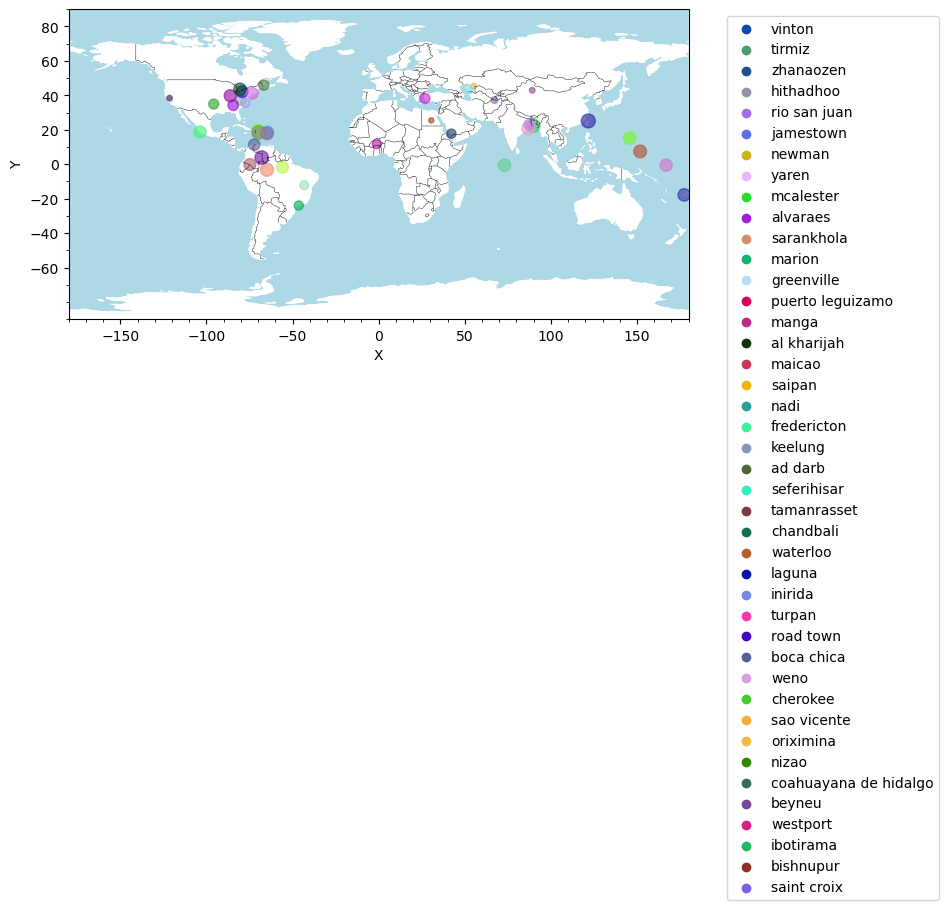

In [61]:
%%capture --no-display
# Configure the map plot

# Create a new figure with a specific projection
fig, ax = plt.subplots(figsize=(8,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Add ocean and land features with specific colors to match the assignment output
ax.add_feature(cfeature.OCEAN, facecolor='lightblue') 
ax.add_feature(cfeature.LAND, facecolor='white')  
# Add countries borders (thing lines)     
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.3)  

# Normalize humidity values for scaling the sizes
size_norm = plt.Normalize(hotel_df['Humidity'].min(), hotel_df['Humidity'].max())

# Generate random colors for different cities
np.random.seed(0)  # for reproducibility
colors = np.random.rand(len(hotel_df), 3)  # generates an array of random colors

# Plot each city with a size and color scaled by 'Humidity'
scatter = ax.scatter(hotel_df['Lng'], hotel_df['Lat'], s=size_norm(hotel_df['Humidity'])*100,  
                     color=colors, alpha=0.6)

# Set x and y labels to match assignment output
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set x and y ticks
ax.set_xticks([-150, -100, -50, 0, 50, 100, 150])
ax.set_yticks([-60, -40, -20, 0, 20, 40, 60, 80])

# Adding a legend with cities to match assignment output
handles = []
for city in hotel_df['City'].unique():
    handles.append(ax.scatter([], [], color=np.random.rand(3,), label=city))

ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add minor ticks for the scale with dividers of 10
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))

# Display the map
plt.show()